In [1]:
import sys
from pathlib import Path

# Get the folder where this notebook is running
notebook_path = Path().resolve()

# Assume 'src' is at the project root, one level up from the notebook folder
project_root = notebook_path.parent

# Construct the full path to src
src_path = project_root / "src"

# Add src to sys.path if not already there
if str(src_path) not in sys.path:
    sys.path.insert(1, str(src_path))

print(f"Added {src_path} to sys.path")

Added /home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/src to sys.path


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn import set_config
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    average_precision_score
)

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import numpy as np
import seaborn as sns
import shap

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [3]:
plt.style.use('ggplot')

random_seed = 42

#set output of skllearn to be a pandas dataframe
set_config(transform_output = "pandas")


# Load Data

In [4]:
#train data
x_train = pd.read_csv('../data/cleaned/train/x_train_cleaned.csv')
x_train_discount = pd.read_csv('../data/cleaned/train/x_train_cleaned_discount.csv')
y_train = pd.read_csv('../data/cleaned/train/y_train.csv')


#test data
x_test  = pd.read_csv('../data/cleaned/test/x_test_cleaned.csv')
x_test_discount  = pd.read_csv('../data/cleaned/test/x_test_cleaned_discount.csv')
y_test  = pd.read_csv('../data/cleaned/test/y_test.csv')



# Train Test Split

In [5]:
#20 % of the data is used for validation
y_train_original = y_train.copy()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train)



In [6]:
x_train_discount, x_val_discount = train_test_split(x_train_discount, test_size = 0.2, 
                                random_state = random_seed,
                                stratify = y_train_original)



# Models


In [7]:
def calculating_metrics(y_true, y_pred, y_pred_proba,
                         model_name,
                         print_results = True):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    if print_results:
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"ROC AUC:   {roc_auc:.4f}")

        print("\nClassification Report:\n")
        print(classification_report(y_val, y_pred))

    results = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }

    results = pd.DataFrame.from_dict(results, orient = 'index')
    results.columns = [model_name]

    return results

In [8]:
def plot_precision_recall_curve(y_true, y_pred_proba):   
    
    
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    avg_precision = average_precision_score(y_val, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## LightGBM

In [9]:
model_lgbm_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    scale_pos_weight = 9.0, 
    n_estimators = 100,
    random_state = 42
)
model_lgbm_no_sampling.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8500
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42, scale_pos_weight=9.0)

In [10]:
y_pred = model_lgbm_no_sampling.predict(x_val)
y_pred_proba = model_lgbm_no_sampling.predict_proba(x_val)[:, 1]  # For AUC

lgbm_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_no_sampling')



Accuracy:  0.5443
Precision: 0.1325
Recall:    0.6652
F1 Score:  0.2209
ROC AUC:   0.6537

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.53      0.68      2110
           1       0.13      0.67      0.22       227

    accuracy                           0.54      2337
   macro avg       0.53      0.60      0.45      2337
weighted avg       0.86      0.54      0.63      2337



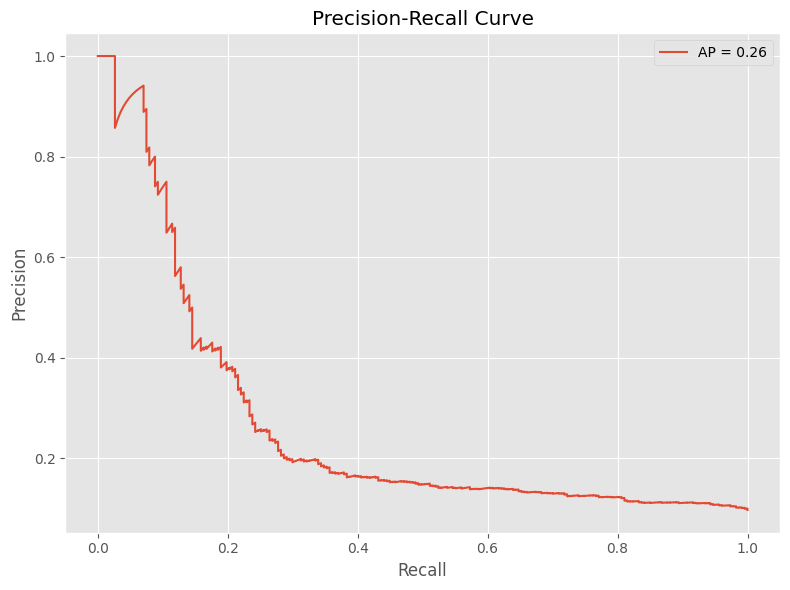

In [11]:
plot_precision_recall_curve(y_val, y_pred_proba)

### Feature Importance

In [12]:
split_importance = model_lgbm_no_sampling.feature_importances_
gain_importance  = model_lgbm_no_sampling.booster_.feature_importance(importance_type = 'gain')

feature_importance = pd.DataFrame({
    "feature": x_train.columns,
    "split_importance": split_importance,
    "gain_importance": gain_importance
}).sort_values("gain_importance", ascending=False)

print(feature_importance.head(10))


                      feature  split_importance  gain_importance
6     forecast_meter_rent_12m               233      7766.833313
11       margin_gross_pow_ele               219      6753.030962
0                    cons_12m               177      5891.441156
14                 net_margin               180      5014.347089
3           forecast_cons_12m               129      4395.010139
19    days_since_modification               153      4308.010819
18             days_until_end               143      4307.752750
17            contract_length               113      4228.930335
49     std_price_off_peak_var               110      3721.926609
29  energy_peak_minus_offpeak               101      3707.633657


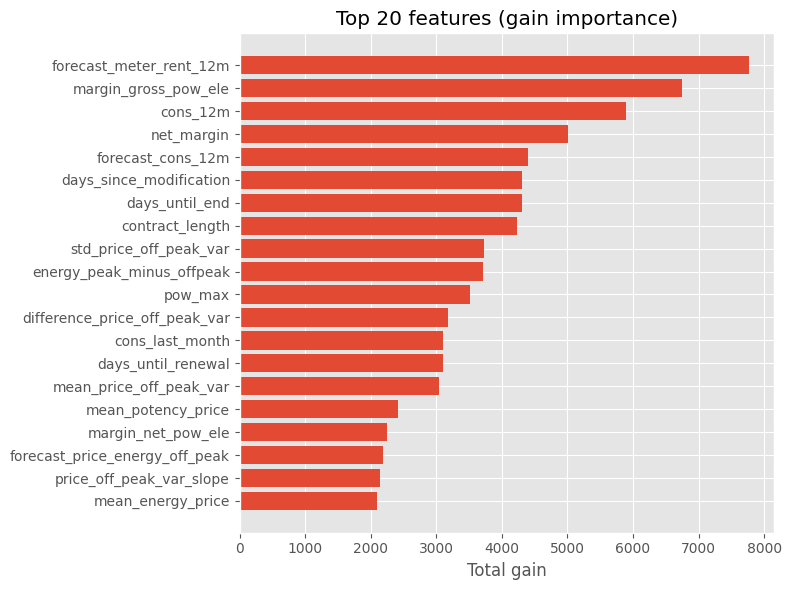

In [13]:
top_k = 20
feature_importance_top = feature_importance.head(top_k).iloc[::-1]        # reverse for horizontal bar

plt.figure(figsize=(8, 6))
plt.barh(feature_importance_top["feature"], feature_importance_top["gain_importance"])
plt.title(f"Top {top_k} features (gain importance)")
plt.xlabel("Total gain")
plt.tight_layout()
plt.show()

## Logistic Regression

In [14]:
clf = LogisticRegression(random_state = random_seed,
                        max_iter = 1000, 
                        class_weight = 'balanced')
clf.fit(x_train, y_train)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [15]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_no_sampling = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_no_sampling')




Accuracy:  0.6119
Precision: 0.1436
Recall:    0.6035
F1 Score:  0.2320
ROC AUC:   0.6569

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.60      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.61      0.49      2337
weighted avg       0.86      0.61      0.69      2337



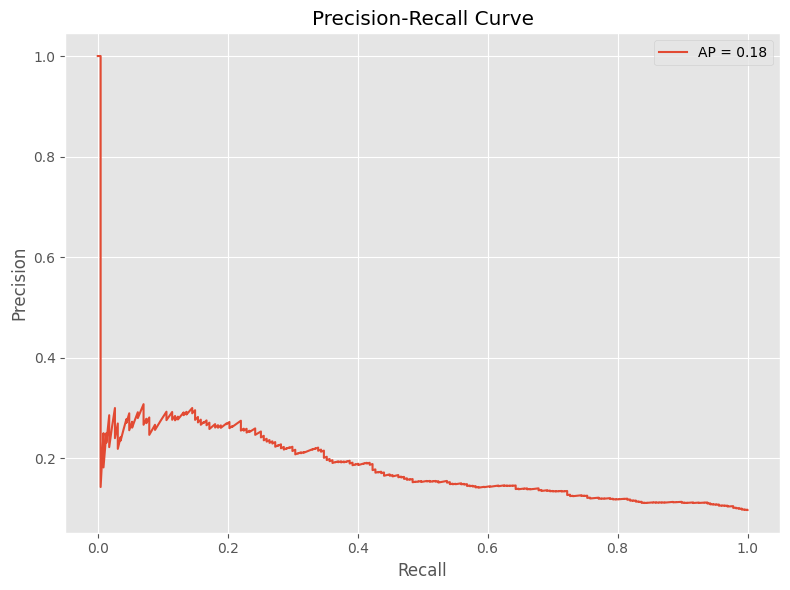

In [16]:
plot_precision_recall_curve(y_val, y_pred_proba)

## Sampling

### Random under-sampling

#### LightGBM

In [17]:
rus = RandomUnderSampler(random_state = random_seed)
x_train_rus_resampled, y_train_rus_resampled = rus.fit_resample(x_train, y_train)

In [18]:
model_lgbm = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)
model_lgbm.fit(x_train_rus_resampled, y_train_rus_resampled)


[LightGBM] [Info] Number of positive: 908, number of negative: 908
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7406
[LightGBM] [Info] Number of data points in the train set: 1816, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [19]:
y_pred = model_lgbm.predict(x_val)
y_pred_proba = model_lgbm.predict_proba(x_val)[:, 1]  # For AUC

lgbm_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'lgbm_rus')


Accuracy:  0.6119
Precision: 0.1344
Recall:    0.5507
F1 Score:  0.2161
ROC AUC:   0.6395

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.74      2110
           1       0.13      0.55      0.22       227

    accuracy                           0.61      2337
   macro avg       0.53      0.58      0.48      2337
weighted avg       0.85      0.61      0.69      2337



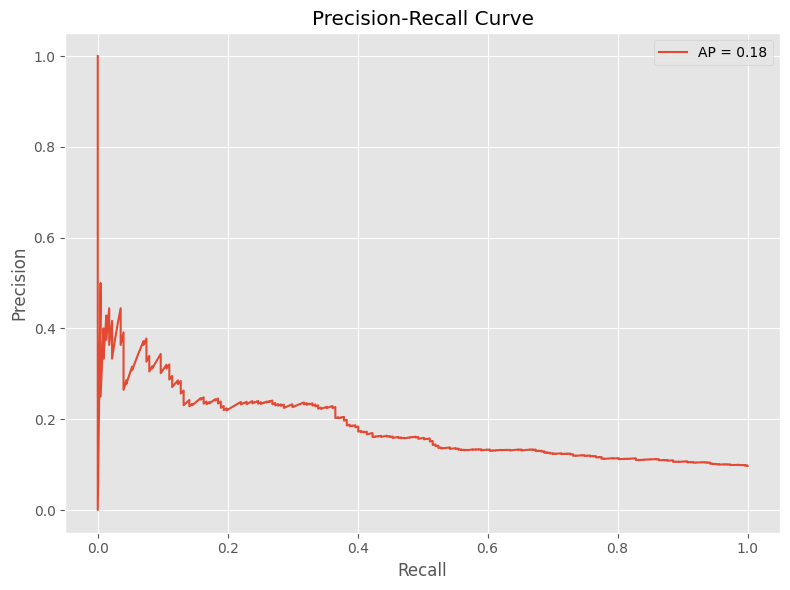

In [20]:
plot_precision_recall_curve(y_val, y_pred_proba)

#### Logistic Regression

In [21]:
clf.fit(x_train_rus_resampled, y_train_rus_resampled)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [22]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_rus = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')


Accuracy:  0.6089
Precision: 0.1411
Recall:    0.5947
F1 Score:  0.2280
ROC AUC:   0.6474

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



### Smote

In [23]:
x_train_smote, y_train_smote = SMOTE(random_state = random_seed).fit_resample(x_train, y_train)


##### LightGBM

In [24]:
model_lgbm.fit(x_train_smote, y_train_smote)


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 8439, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13027
[LightGBM] [Info] Number of data points in the train set: 16878, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

In [25]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

lgbm_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_smote')


Accuracy:  0.6089
Precision: 0.1411
Recall:    0.5947
F1 Score:  0.2280
ROC AUC:   0.6474

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.61      2337
   macro avg       0.54      0.60      0.48      2337
weighted avg       0.86      0.61      0.69      2337



#### Logistic Regression

In [26]:
clf.fit(x_train_smote, y_train_smote)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [27]:
y_pred = clf.predict(x_val)
y_pred_proba = clf.predict_proba(x_val)[:, 1]  # For AUC

logistic_smote = calculating_metrics(y_val, y_pred, y_pred_proba, 'logistic_rus')

Accuracy:  0.6170
Precision: 0.1424
Recall:    0.5859
F1 Score:  0.2291
ROC AUC:   0.6534

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      2110
           1       0.14      0.59      0.23       227

    accuracy                           0.62      2337
   macro avg       0.54      0.60      0.49      2337
weighted avg       0.86      0.62      0.70      2337



## Feature Selection

Model-based feature importance

In [28]:
selector = SelectFromModel(model_lgbm_no_sampling, threshold="median", prefit=True)
x_train_selected = selector.transform(x_train)
x_val_selected = selector.transform(x_val)
x_test_selected = selector.transform(x_test)

/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [29]:
model_selected_no_sampling = LGBMClassifier(
    class_weight = 'balanced', 
    n_estimators = 100,
    random_state = 42
)

model_selected_no_sampling.fit(x_train_selected, y_train)

[LightGBM] [Info] Number of positive: 908, number of negative: 8439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7854
[LightGBM] [Info] Number of data points in the train set: 9347, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rodolfo/Documents/Rodolfo/Python_Projects/projetos_sem_espacos/churn-powerco/powerco-churn/env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(class_weight='balanced', random_state=42)

In [30]:
y_pred = model_selected_no_sampling.predict(x_val_selected)
y_pred_proba = model_selected_no_sampling.predict_proba(x_val_selected)[:, 1]  # For AUC
lgbm_no_sampling_selected = calculating_metrics(y_val, y_pred, y_pred_proba, 'lightgbm_ns_selected')

Accuracy:  0.8194
Precision: 0.2206
Recall:    0.3392
F1 Score:  0.2674
ROC AUC:   0.6734

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      2110
           1       0.22      0.34      0.27       227

    accuracy                           0.82      2337
   macro avg       0.57      0.61      0.58      2337
weighted avg       0.86      0.82      0.84      2337



## Results - Comparisson

In [31]:
results = pd.concat([lgbm_no_sampling, lgbm_rus, lgbm_smote, lgbm_no_sampling_selected, 
                logistic_no_sampling, logistic_rus, logistic_smote], axis = 1)

In [32]:
results

,lgbm_no_sampling,lgbm_rus,lightgbm_smote,lightgbm_ns_selected,logistic_no_sampling,logistic_rus,logistic_rus
accuracy,0.544288,0.611896,0.608900,0.819427,0.611896,0.608900,0.617030
precision,0.132456,0.134409,0.141066,0.220630,0.143606,0.141066,0.142398
recall,0.665198,0.550661,0.594714,0.339207,0.603524,0.594714,0.585903
f1,0.220922,0.216076,0.228041,0.267361,0.232007,0.228041,0.229113
roc_auc,0.653740,0.639476,0.647381,0.673369,0.656928,0.647381,0.653429


## Discount Effect

In [33]:
x_val = x_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [34]:
y_pred_proba_no_discount = model_lgbm_no_sampling.predict_proba(x_val)
y_pred_proba_no_discount = pd.DataFrame(y_pred_proba_no_discount, columns = ['prob_not_churned', 'prob_churned'])
y_pred_proba_no_discount = pd.concat([y_pred_proba_no_discount, y_val], axis = 1)
y_pred_proba_no_discount


,prob_not_churned,prob_churned,churn
0,0.390424,0.609576,0
1,0.793773,0.206227,1
2,0.599205,0.400795,0
3,0.098485,0.901515,0
4,0.941350,0.058650,0
...,...,...,...
2332,0.815263,0.184737,0
2333,0.818704,0.181296,0
2334,0.895526,0.104474,0
2335,0.662414,0.337586,0


In [35]:
churned_no_discount = y_pred_proba_no_discount[y_pred_proba_no_discount['churn'] == 1]

n_churned = len(churned_no_discount)
n_correct_preds = len(churned_no_discount[churned_no_discount['prob_churned'] > 0.5])

print('Number of churned no discount:', n_churned)
print('Number of correct predictions no discount:', n_correct_preds)
print(f'Proportion: {100*n_correct_preds/n_churned:.2f}%')



Number of churned no discount: 227
Number of correct predictions no discount: 151
Proportion: 66.52%


Text(0.5, 0, 'Sample')

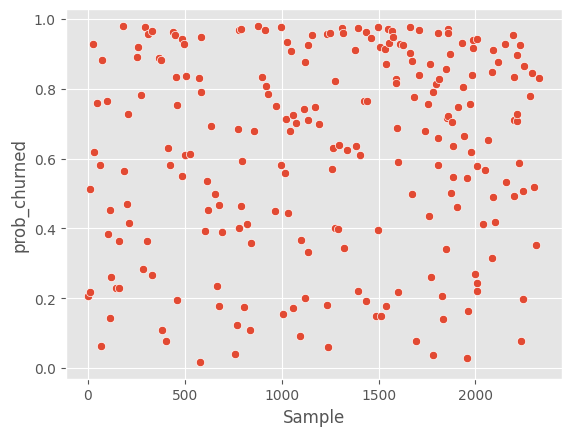

In [36]:
sns.scatterplot(x = churned_no_discount.index, y = churned_no_discount['prob_churned'])
plt.xlabel('Sample')


In [37]:
y_pred_proba_discount = model_lgbm_no_sampling.predict_proba(x_val_discount)
y_pred_proba_discount = pd.DataFrame(y_pred_proba_discount, columns = ['prob_not_churned_discount', 'prob_churned_discount'])
y_pred_proba_discount = pd.concat([y_pred_proba_discount, y_val], axis = 1)
y_pred_proba_discount

,prob_not_churned_discount,prob_churned_discount,churn
0,0.433757,0.566243,0
1,0.907122,0.092878,1
2,0.901328,0.098672,0
3,0.436046,0.563954,0
4,0.974487,0.025513,0
...,...,...,...
2332,0.814631,0.185369,0
2333,0.838271,0.161729,0
2334,0.831558,0.168442,0
2335,0.434920,0.565080,0


In [38]:
churned_discount = y_pred_proba_discount[y_pred_proba_discount['churn'] == 1]
n_pred_chrurned_discount = len(churned_discount[churned_discount['prob_churned_discount'] > 0.5])

print('Number of churned predictions:', n_pred_chrurned_discount)

Number of churned predictions: 98


Text(0.5, 0, 'Sample')

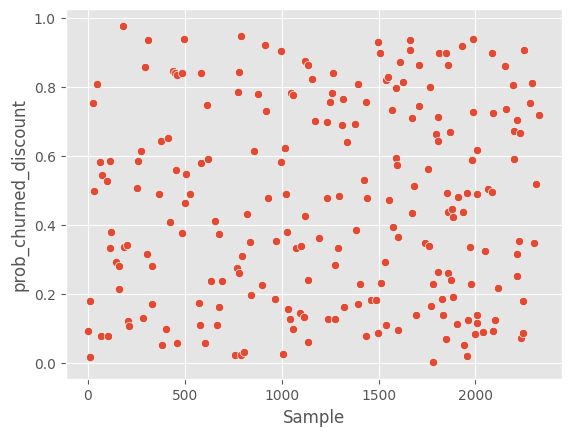

In [39]:
sns.scatterplot(x = churned_discount.index, y = churned_discount['prob_churned_discount'])
plt.xlabel('Sample')

Text(0, 0.5, 'Predicted probability')

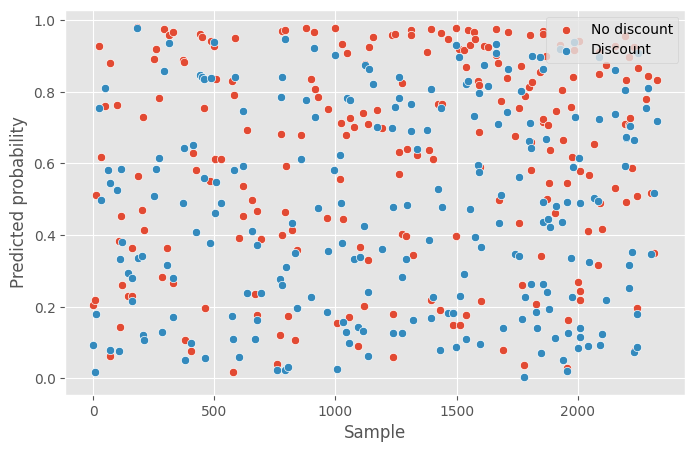

In [40]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x = churned_no_discount.index, y = churned_no_discount['prob_churned'], label = 'No discount')
sns.scatterplot(x = churned_discount.index, y = churned_discount['prob_churned_discount'], label = 'Discount')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Predicted probability')


In [41]:
comparison = pd.concat([churned_no_discount, churned_discount], axis = 1)
comparison = comparison.loc[comparison['prob_churned'] > 0.5, ['prob_churned', 'prob_churned_discount']]

In [42]:
comparison

,prob_churned,prob_churned_discount
13,0.512064,0.180544
25,0.927802,0.754010
31,0.619112,0.498874
49,0.760069,0.809354
61,0.582868,0.582849
...,...,...
2251,0.866346,0.907385
2283,0.780446,0.754220
2290,0.844172,0.812028
2302,0.517469,0.348289


Text(0, 0.5, 'Predicted probability')

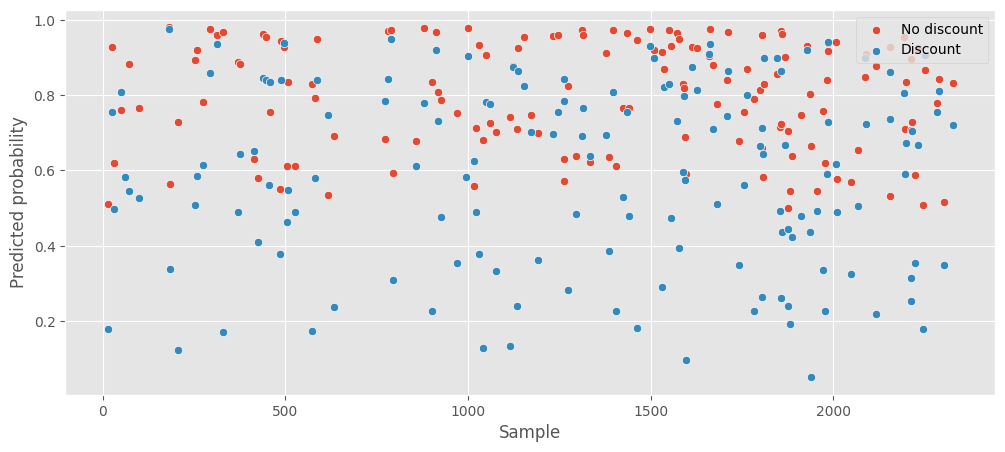

In [43]:
plt.figure(figsize=(12, 5))

sns.scatterplot(x = comparison.index, y = comparison['prob_churned'], label = 'No discount')
sns.scatterplot(x = comparison.index, y = comparison['prob_churned_discount'], label = 'Discount')
plt.legend(loc='upper right')
plt.xlabel('Sample')
plt.ylabel('Predicted probability')

## Shap

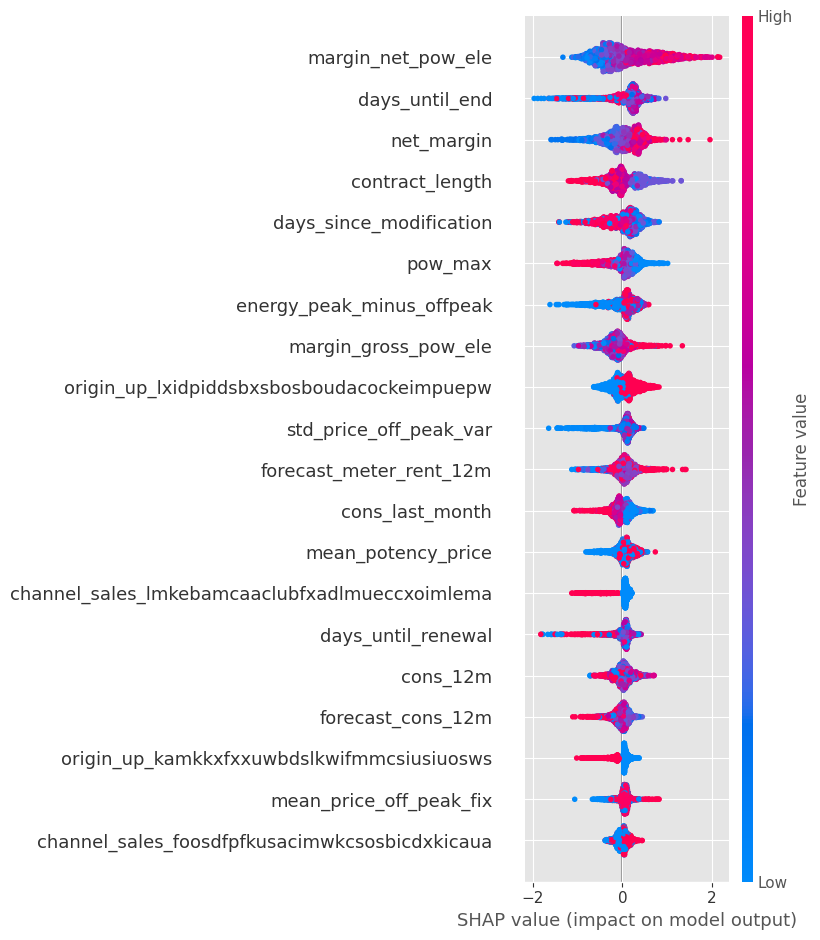

In [44]:
explainer = shap.TreeExplainer(model_lgbm_no_sampling)
shap_values_no_discount = explainer(x_val)
shap.summary_plot(shap_values_no_discount, x_val)


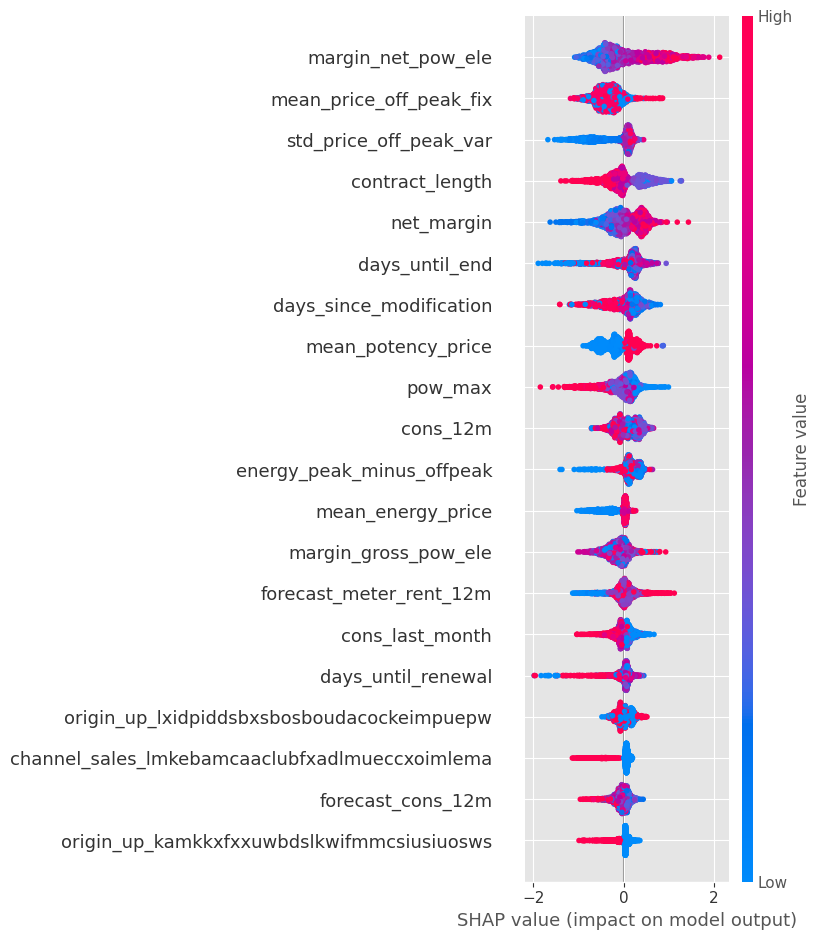

In [45]:
shap_values_discount = explainer(x_val_discount)
shap.summary_plot(shap_values_discount, x_val_discount)

### Individual Predictions

In [46]:
y_pred_proba_no_discount.sort_values(by = 'prob_churned', ascending = False)

,prob_not_churned,prob_churned,churn
181,0.019714,0.980286,1
880,0.020736,0.979264,1
999,0.021903,0.978097,1
1499,0.023235,0.976765,1
1663,0.023874,0.976126,1
...,...,...,...
721,0.998435,0.001565,0
32,0.998524,0.001476,0
419,0.999465,0.000535,0
1368,0.999638,0.000362,0


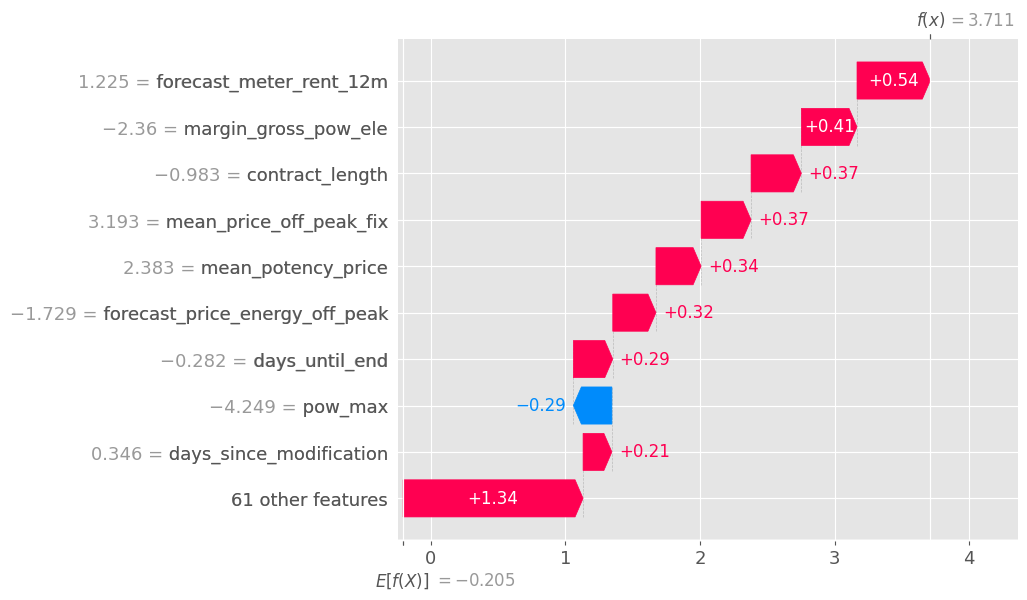

In [47]:
explainer_no_discount = shap.Explainer(model_lgbm_no_sampling, x_val)
shap_values = explainer(x_val)
shap.plots.waterfall(shap_values[1663])

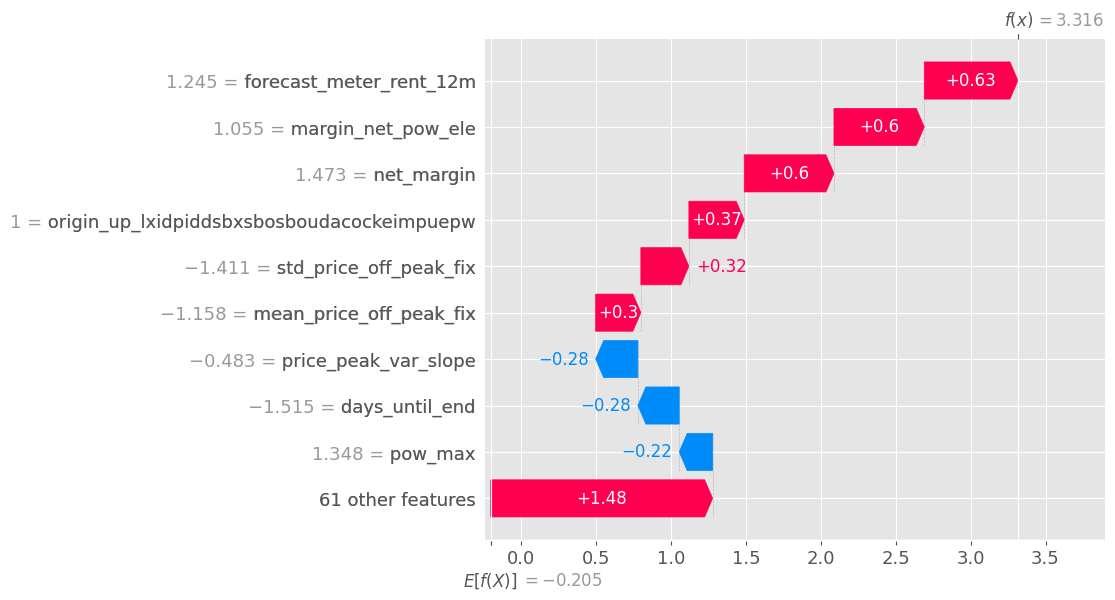

In [48]:
shap.plots.waterfall(shap_values[430])

# Mlflow

In [49]:
mlflow.set_tracking_uri("file:../mlruns")  # Goes one level up
mlflow.set_experiment("powerco_churn")

with mlflow.start_run(run_name="ML_notebook"):
    mlflow.log_artifact("ML.ipynb")